## Bootstrap

#### Table of Contents

* [Preliminaries](#Preliminaries)
* [Estimates](#Estimates)
* [Bootstrapping](#Bootstrapping)
* [Visualizing](#Visualizing)

In *__this__* application, we will use bootstrapping for inference; we will estimate the distribution of a coefficient. 
This should hint that we can use bootstrapping for *other* machine learning applications.

I think it would be interesting to replicate the lecture figures, so let's do it with commentary!

*********
# Preliminaries
[TOP](#Bootstrap)

We are going to need a variety of functions and packages. I should point out that we are using `scipy.stats.norm.pdf()` function to produce a normal distribution.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'axes.titlesize': 24,
             'axes.labelsize': 20,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'figure.figsize': (8, 4.5),
             'figure.dpi': 160})

In [2]:
df = pd.read_pickle('C:/Users/hubst/Econ490_group/class_data.pkl')

***
# Estimates
[TOP](#Bootstrap)

First, we shall estimate the coefficient for comparison.

In [3]:
reg = smf.ols(formula = 'pos_net_jobs ~ estabs_entry_rate', data = df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           pos_net_jobs   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1491.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          2.22e-321
Time:                        14:33:06   Log-Likelihood:                -35264.
No. Observations:               50127   AIC:                         7.053e+04
Df Residuals:                   50125   BIC:                         7.055e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2974      0.00

We need to grab the estimate and the standard error for plotting:

In [4]:
m = reg.params[1]
s = reg.bse[1]

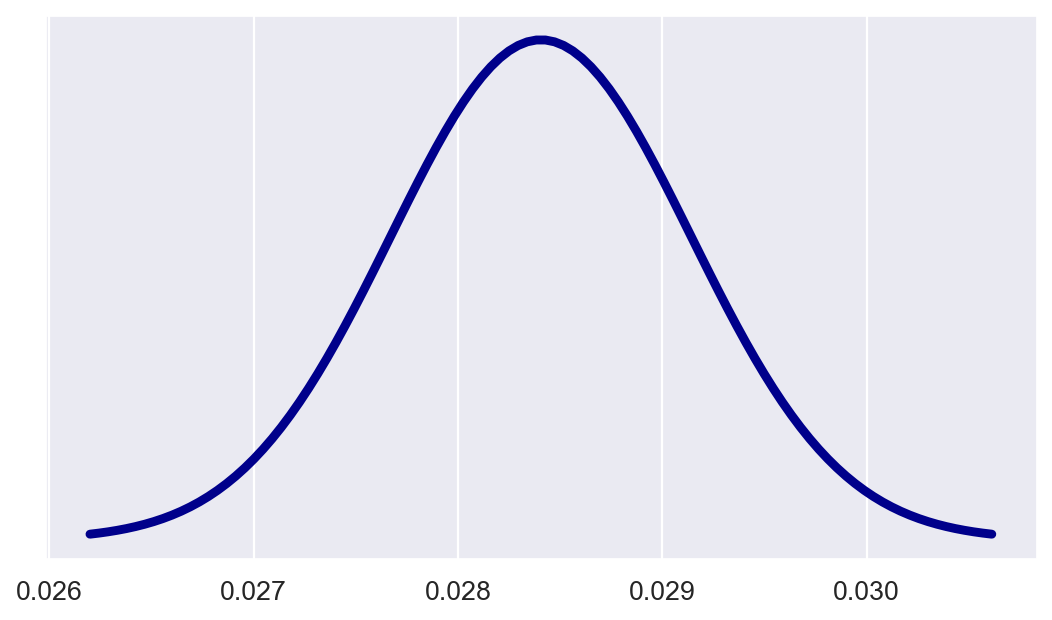

In [5]:
x = np.linspace(m - 3*s, m + 3*s, 100)

plt.plot(x, stats.norm.pdf(x, m, s), linewidth = 4, color = 'darkblue')
plt.yticks([])

plt.savefig('beta dist', dpi = 160)

************
# Bootstrapping 
[TOP](#Bootstrap)

When you think **random**, you should think set seed. 
We will be using `np.random.choice()` which has the default argument of `replace = True`.

I also think `tqdm` makes a pretty progress bar!

We need to save the estimates, so we will first create an empty list to store the results.

In [6]:
np.random.seed(490)

n = df.shape[0]

beta = []

for i in tqdm(range(1000)):
    indx = np.random.choice(range(n), n)
    reg = smf.ols(formula = 'pos_net_jobs ~ estabs_entry_rate', data = df.iloc[indx]).fit()
    beta.append(reg.params[1])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.90it/s]


Excellent!
Now, let's take a look at the mean and standard deviation.

In [7]:
print('OLS Estimate: %.4f\nBootstrap Avg.: %.4f' %  (m, np.mean(beta)))

OLS Estimate: 0.0284
Bootstrap Avg.: 0.0284


Here's a fun question! 
Does the estimate lie within the 95% confidence interval?

In [8]:
lower = reg.conf_int().iloc[1, 0]
upper = reg.conf_int().iloc[1, 1]

(np.mean(beta) > lower) & (np.mean(beta) < upper)

False

NOICE!

***
# Visualizing
[TOP](#Bootstrap)

Finally, we can produce a lovely figure with the empirical distribution (nomal PDF) imposed on top of the empirical distribution (histogram).

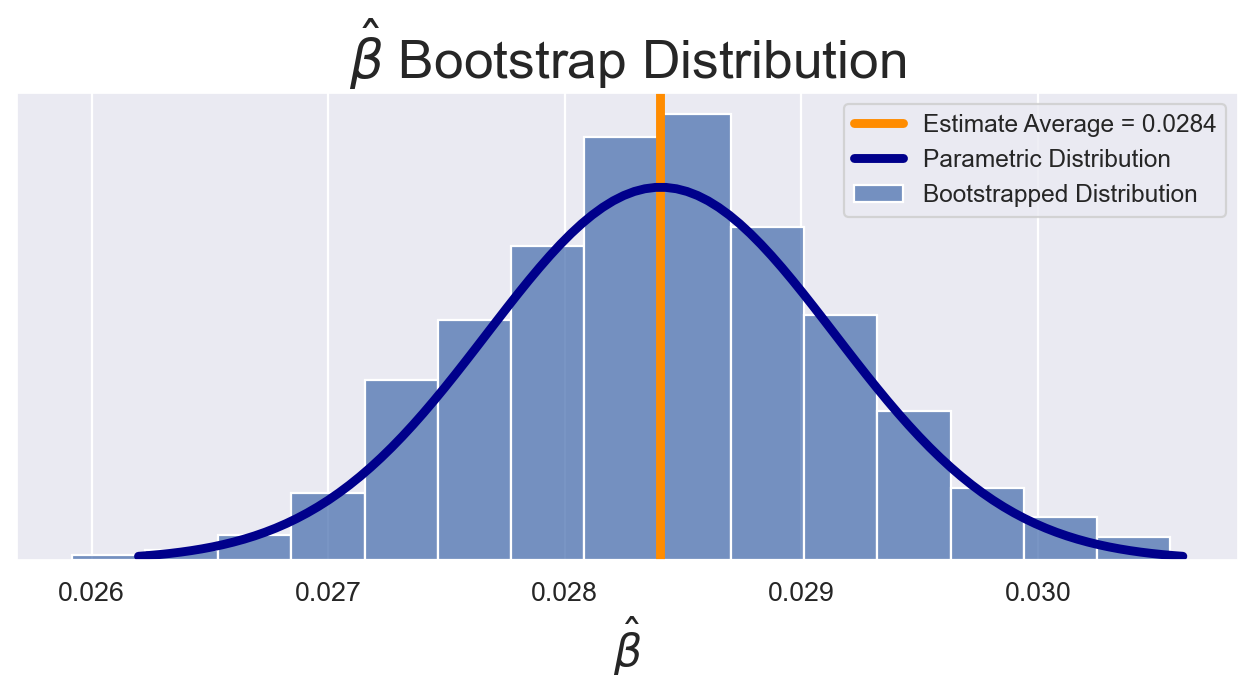

In [9]:
sns.histplot(beta, bins = 15, label = 'Bootstrapped Distribution')
plt.axvline(x = np.mean(beta), ymin = 0, ymax = 210, color = 'darkorange', linewidth = 4, label = 'Estimate Average = {0:.4f}'.format(np.mean(beta)))
plt.plot(x, stats.norm.pdf(x, m, s)/3.75, color = 'darkblue', linewidth = 4, label = 'Parametric Distribution')

plt.yticks([])
plt.ylabel('')
plt.legend()
plt.title('$\\hat{\\beta}$ Bootstrap Distribution')
plt.xlabel('$\\hat{\\beta}$')

plt.tight_layout()